In [1]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# Read the dataset
df = pd.read_csv('../../Dataset/ACB-Historical-Data_Group-9.csv',index_col='Date', parse_dates=True)
df.dropna() #Drop missing value
df = df.sort_values(by='Date', ascending=True)
df =df.reset_index(drop=True) #Reset the index

In [3]:
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'], df['Open'], df['High'], df['Low'] = [df[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

print(df)

        Price     Open     High      Low      Vol.  Change %
0     11361.0  11285.2  11398.8  11171.6   3910000    0.0101
1     11512.4  11361.0  11550.3  11323.1   8240000    0.0133
2     11474.6  11512.4  11626.0  11398.8   6510000   -0.0033
3     11474.6  11436.7  11512.4  11361.0   3110000    0.0000
4     11550.3  11512.4  11626.0  11474.6   8720000    0.0066
...       ...      ...      ...      ...       ...       ...
1303  29450.0  29500.0  29850.0  29250.0   7540000    0.0068
1304  29650.0  29700.0  29700.0  29300.0  10690000    0.0068
1305  29250.0  29700.0  29750.0  29250.0  13450000   -0.0135
1306  25565.2  25347.8  25565.2  25087.0  15080000   -0.1260
1307  24650.0  25000.0  25300.0  24650.0  11120000   -0.0358

[1308 rows x 6 columns]


In [4]:
price=df.reset_index()['Price']
price

0       11361.0
1       11512.4
2       11474.6
3       11474.6
4       11550.3
         ...   
1303    29450.0
1304    29650.0
1305    29250.0
1306    25565.2
1307    24650.0
Name: Price, Length: 1308, dtype: float64

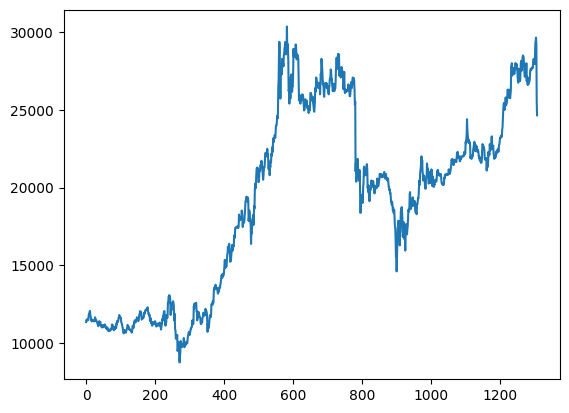

In [5]:
plt.plot(price)

## LSTM are sentitive to the scale of the data => apply MinMax schaler

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
price_scaled=scaler.fit_transform(np.array(price).reshape(-1,1))

In [7]:
# 4. split the data into train and test
train_size = int(0.8 * len(price_scaled))
test_size = len(price_scaled) - train_size 

train_data = price_scaled[0:train_size,:]
test_data = price_scaled[train_size:len(price_scaled),:1]

In [8]:
#Training process
# a. convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# Sử dụng look_back để tạo tập huấn luyện và tập kiểm tra
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# c. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# Kiểm tra hình dạng của dữ liệu
print(f'X_train shape: {X_train.shape}, Y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, Y_test shape: {y_test.shape}')

X_train shape: (1015, 30, 1), Y_train shape: (1015,)
X_test shape: (231, 30, 1), Y_test shape: (231,)


In [10]:
X_train.shape[1]

30

In [11]:
#6. Xây dựng mô hình và train mô hình
model=Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# Compile model
model.compile(loss='mean_squared_error',optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

d:\install package\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.1397 - val_loss: 0.0025
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0063 - val_loss: 0.0030
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0023 - val_loss: 9.4640e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0016 - val_loss: 9.1608e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0017 - val_loss: 9.0822e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0015 - val_loss: 9.7008e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0015 - val_loss: 9.8850e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 12/100
16/16 ━━━━━━━━━━━━━

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,885 (198.77 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,924 (132.52 KB)

In [13]:
# 7. Dự báo trên tập test
y_pred=model.predict(X_test)

y_pred=scaler.inverse_transform(y_pred)

##Transformback to original form
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [14]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

next_30_days = scaler.inverse_transform(lst_output_30)        

print(next_30_days)

[[26135.02904649]
 [25463.26429929]
 [25090.74091436]
 [24903.659871  ]
 [24829.67242133]
 [24819.67543939]
 [24839.83288727]
 [24868.01263639]
 [24890.86692656]
 [24901.43159702]
 [24897.14496943]
 [24878.26321162]
 [24846.67346956]
 [24805.00178536]
 [24756.02996151]
 [24702.30036721]
 [24645.94601806]
 [24588.62621225]
 [24531.51494508]
 [24475.38072005]
 [24420.66893451]
 [24367.58169071]
 [24316.1434469 ]
 [24266.28597746]
 [24217.87025665]
 [24170.74438594]
 [24124.76161592]
 [24079.78034628]
 [24035.68086039]
 [23992.37433625]]


In [15]:
# 12. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

next_60_days = scaler.inverse_transform(lst_output_60)        
print(next_60_days)

[[26135.02904649]
 [25463.26429929]
 [25090.74091436]
 [24903.659871  ]
 [24829.67242133]
 [24819.67543939]
 [24839.83288727]
 [24868.01263639]
 [24890.86692656]
 [24901.43159702]
 [24897.14496943]
 [24878.26321162]
 [24846.67346956]
 [24805.00178536]
 [24756.02996151]
 [24702.30036721]
 [24645.94601806]
 [24588.62621225]
 [24531.51494508]
 [24475.38072005]
 [24420.66893451]
 [24367.58169071]
 [24316.1434469 ]
 [24266.28597746]
 [24217.87025665]
 [24170.74438594]
 [24124.76161592]
 [24079.78034628]
 [24035.68086039]
 [23992.37433625]
 [23949.78482459]
 [23907.85825983]
 [23866.55602372]
 [23825.84078526]
 [23785.69580988]
 [23746.11208663]
 [23707.06644456]
 [23668.55630913]
 [23630.56494574]
 [23593.0872053 ]
 [23556.11150232]
 [23519.62882588]
 [23483.63145232]
 [23448.10522162]
 [23413.04112284]
 [23378.4327196 ]
 [23344.26713915]
 [23310.53665785]
 [23277.22840292]
 [23244.3410871 ]
 [23211.85926307]
 [23179.77778175]
 [23148.08634492]
 [23116.77722892]
 [23085.85043377]
 [23055.28

In [16]:
# 12. Dự báo 90 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

next_90_days = scaler.inverse_transform(lst_output_90)        
print(next_90_days)

[[26135.02904649]
 [25463.26429929]
 [25090.74091436]
 [24903.659871  ]
 [24829.67242133]
 [24819.67543939]
 [24839.83288727]
 [24868.01263639]
 [24890.86692656]
 [24901.43159702]
 [24897.14496943]
 [24878.26321162]
 [24846.67346956]
 [24805.00178536]
 [24756.02996151]
 [24702.30036721]
 [24645.94601806]
 [24588.62621225]
 [24531.51494508]
 [24475.38072005]
 [24420.66893451]
 [24367.58169071]
 [24316.1434469 ]
 [24266.28597746]
 [24217.87025665]
 [24170.74438594]
 [24124.76161592]
 [24079.78034628]
 [24035.68086039]
 [23992.37433625]
 [23949.78482459]
 [23907.85825983]
 [23866.55602372]
 [23825.84078526]
 [23785.69580988]
 [23746.11208663]
 [23707.06644456]
 [23668.55630913]
 [23630.56494574]
 [23593.0872053 ]
 [23556.11150232]
 [23519.62882588]
 [23483.63145232]
 [23448.10522162]
 [23413.04112284]
 [23378.4327196 ]
 [23344.26713915]
 [23310.53665785]
 [23277.22840292]
 [23244.3410871 ]
 [23211.85926307]
 [23179.77778175]
 [23148.08634492]
 [23116.77722892]
 [23085.85043377]
 [23055.28

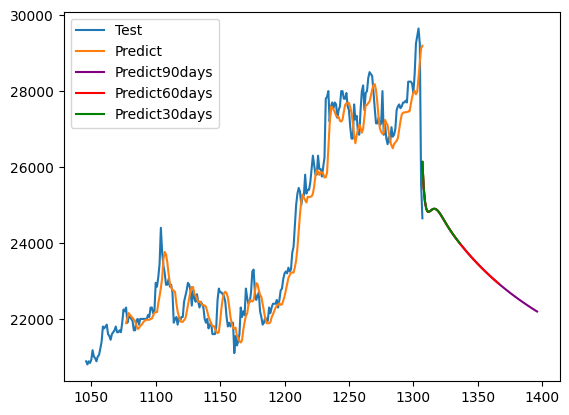

In [17]:
# 15. Vẽ hình dự báo 30 ngày tiếp theo

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

predict_data_index_90 = pd.RangeIndex(start=len(price)-1, stop=len(price)+89, step=1)
plt.plot(predict_data_index_90,next_90_days, color='purple')
predict_data_index_60 = pd.RangeIndex(start=len(price)-1, stop=len(price)+59, step=1)
plt.plot(predict_data_index_60,next_60_days, color='red')
predict_data_index_30 = pd.RangeIndex(start=len(price)-1, stop=len(price)+29, step=1)
plt.plot(predict_data_index_30,next_30_days, color='green')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])

plt.show()

In [18]:
# 12. Đánh giá độ chính xác thuật toán 
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)   

Testing RMSE: 495.0181286410321
Testing MAE: 331.5677725919914
Testing MAPE: 0.013253986912021587
